In [7]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw
from scipy.optimize import curve_fit
from scipy.stats import chi2

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [8]:
def convert_KM(sds):
    lon_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lon']
    lon_tmp = lon_tmp//100 + (lon_tmp - lon_tmp//100*100)/60
    lat_tmp = sds[(sds['cruise']=='KiloMoana_1')]['lat']
    lat_tmp = lat_tmp//100 + (lat_tmp - lat_tmp//100*100)/60
    
    sds.loc[sds['cruise']=='KiloMoana_1','lon'] = -lon_tmp
    sds.loc[sds['cruise']=='KiloMoana_1','lat'] = lat_tmp
    
    lon_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lon']
    lon_tmp2 = lon_tmp2//100 + (lon_tmp2 - lon_tmp2//100*100)/60
    lat_tmp2 = sds[(sds['cruise']=='SCOPE_2')]['lat']
    lat_tmp2 = lat_tmp2//100 + (lat_tmp2 - lat_tmp2//100*100)/60
    
    sds.loc[sds['cruise']=='SCOPE_2','lon'] = -lon_tmp2
    sds.loc[sds['cruise']=='SCOPE_2','lat'] = lat_tmp2
    
    return sds

def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance(data):
    cruise = pd.unique(data['cruise'])
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data  

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments


def interpdata(track, aa, bb, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    intdata = pd.DataFrame()
    # set the interpolation distance 
    n = 1 # 1km 
    begin = np.floor(track['x'][:1])
    intdata['x'] = np.arange(aa, bb, n)
 
    for v in var:
        intdata[v] = np.interp(intdata['x'].values,track['x'].values,track[v].values)
          
    return intdata


In [9]:
# import data
filePath = '/Users/archie/Google Drive/seaflow_data/KM1_abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')
print data.columns

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/archie/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)

filePath = '/Users/archie/Google Drive/seaflow_data/KM1_chl.csv'
chl = pd.read_csv(filePath, sep=',')

Index([u'Unnamed: 0', u'cruise', u'file_time', u'opp_evt_ratio', u'flow_rate',
       u'beads', u'picoeuk', u'prochloro', u'synecho', u'unknown', u'cocco',
       u'ts', u'file_duration', u'pico', u'Unnamed: 0.1', u'tot_chl',
       u'file_time_r', u'Unnamed: 0.1', u'file_duration_r', u'lat', u'lon',
       u'conductivity', u'salinity', u'ocean_tmp', u'par', u'bulk_red',
       u'stream_pressure', u'flow_rate_r', u'event_rate', u'avg_chl',
       u'avg_pe', u'avg_fsc', u'density', u'lon_e', u'dx', u'x', u'sds_time',
       u'file_time_r.1', u'opp.evt'],
      dtype='object')


In [10]:
# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = pd.merge(data, chl, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk', 'chl']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean = distance(clean)


/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
# look for correlations between variables over the entire cruise track
clean.corr()



,lon,lon_e,lat,depth,dcoast,salinity,ocean_tmp,density,pico,synecho,picoeuk,chl,tot_chl,dx,x
lon,1.000000,1.000000,0.751694,0.842161,-0.564667,-0.792679,-0.759462,0.317966,-0.488513,0.536684,0.170639,0.527697,0.032492,-0.065404,-0.926388
lon_e,1.000000,1.000000,0.751694,0.842161,-0.564667,-0.792679,-0.759462,0.317966,-0.488513,0.536684,0.170639,0.527697,0.032492,-0.065404,-0.926388
lat,0.751694,0.751694,1.000000,0.537517,-0.192628,-0.942439,-0.963168,0.669741,-0.798800,0.451297,0.615968,0.293611,-0.185894,-0.042456,-0.944212
depth,0.842161,0.842161,0.537517,1.000000,-0.744561,-0.691840,-0.668196,0.221794,-0.293634,0.396922,0.074368,0.725001,-0.039488,-0.047895,-0.732526
dcoast,-0.564667,-0.564667,-0.192628,-0.744561,1.000000,0.250082,0.324910,-0.277072,0.283556,-0.321973,-0.117261,-0.386722,-0.236237,0.025294,0.400672
salinity,-0.792679,-0.792679,-0.942439,-0.691840,0.250082,1.000000,0.963630,-0.479169,0.654562,-0.452701,-0.452788,-0.498027,0.234177,0.050486,0.933737
ocean_tmp,-0.759462,-0.759462,-0.963168,-0.668196,0.324910,0.963630,1.000000,-0.689563,0.748681,-0.430365,-0.599616,-0.468956,0.268686,0.039679,0.931344
density,0.317966,0.317966,0.669741,0.221794,-0.277072,-0.479169,-0.689563,1.000000,-0.776444,0.230273,0.794053,0.045509,-0.214087,0.008027,-0.546516
pico,-0.488513,-0.488513,-0.798800,-0.293634,0.283556,0.654562,0.748681,-0.776444,1.000000,-0.527416,-0.698366,0.092818,0.014969,0.000586,0.700088
synecho,0.536684,0.536684,0.451297,0.396922,-0.321973,-0.452701,-0.430365,0.230273,-0.527416,1.000000,0.120492,-0.000599,0.358169,-0.057033,-0.525376


In [19]:
# look at correlations for each segment individually
segments = tracks(clean)


for k in range(1, len(segments)+1):
    a = segments['start'][k]
    b = segments['end'][k]
        
    tmp = data[['density', 'ocean_tmp', 'salinity', 'synecho', 'pico', 'picoeuk', 'chl']][a:b]
    
    pval = np.zeros([tmp.shape[1],tmp.shape[1]])
    for i in range(tmp.shape[1]): # rows are the number of rows in the matrix.
        for j in range(tmp.shape[1]):
            JonI        = pd.ols(y=tmp.icol(i), x=tmp.icol(j), intercept=True)
            pval[i,j]  = np.round(JonI.f_stat['p-value'],3)

    
    print 'segment', k
    print tmp.corr()
    print pval
    del tmp, pval

segment 1
            density  ocean_tmp  salinity   synecho  pico   picoeuk       chl
density    1.000000  -0.602600  0.958690 -0.810807   NaN  0.539534 -0.123513
ocean_tmp -0.602600   1.000000 -0.350701  0.213386   NaN -0.018100 -0.062321
salinity   0.958690  -0.350701  1.000000 -0.875508   NaN  0.626676 -0.167270
synecho   -0.810807   0.213386 -0.875508  1.000000   NaN -0.487898  0.239488
pico            NaN        NaN       NaN       NaN   NaN       NaN       NaN
picoeuk    0.539534  -0.018100  0.626676 -0.487898   NaN  1.000000  0.054815
chl       -0.123513  -0.062321 -0.167270  0.239488   NaN  0.054815  1.000000
[[ 0.     0.     0.     0.       nan  0.     0.047]
 [ 0.     0.     0.     0.001    nan  0.771  0.317]
 [ 0.     0.     0.     0.       nan  0.     0.007]
 [ 0.     0.001  0.     0.       nan  0.     0.   ]
 [   nan    nan    nan    nan    nan    nan    nan]
 [ 0.     0.771  0.     0.       nan  0.     0.379]
 [ 0.047  0.317  0.007  0.     0.     0.379  0.   ]]
segment 2

/Users/archie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: FutureWarning: icol(i) is deprecated. Please use .iloc[:,i]


Segment 1


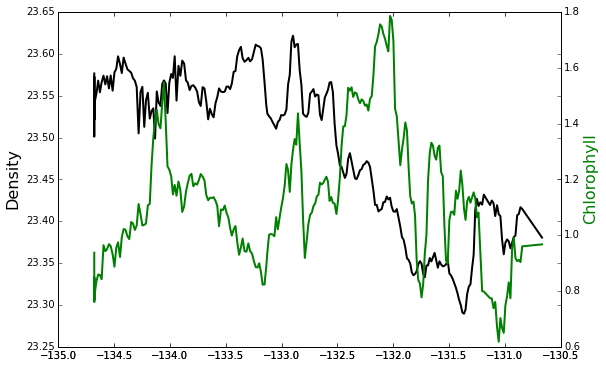

Segment 2


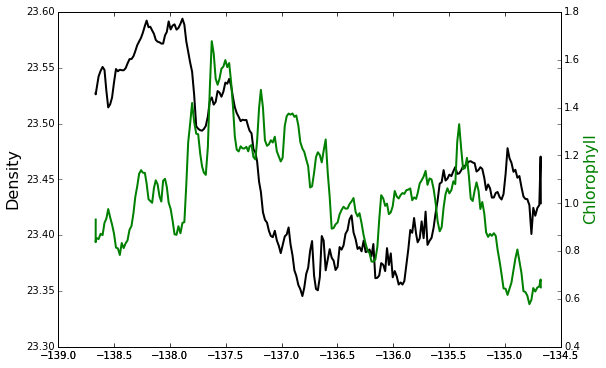

Segment 3


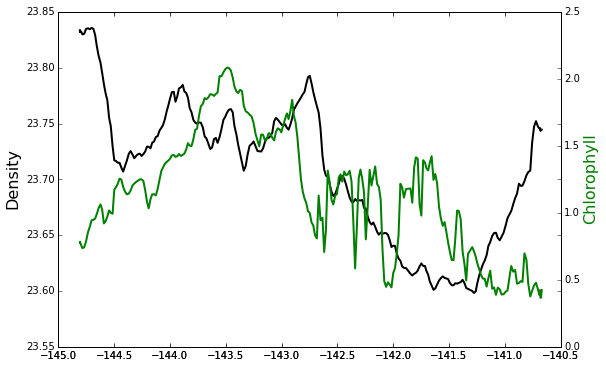

Segment 4


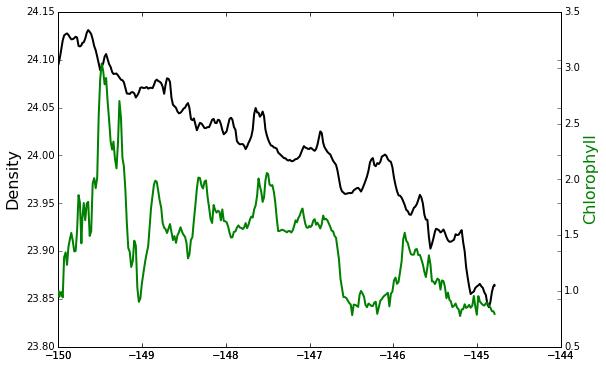

Segment 5


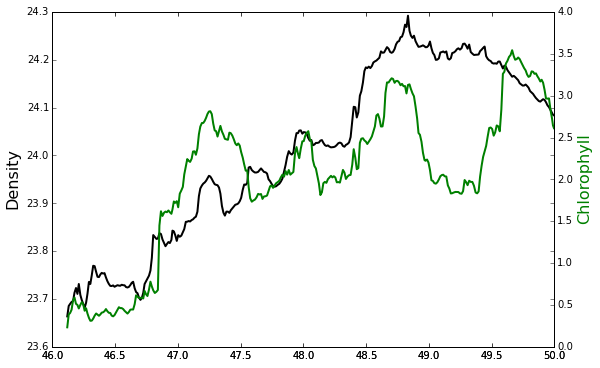

Segment 6


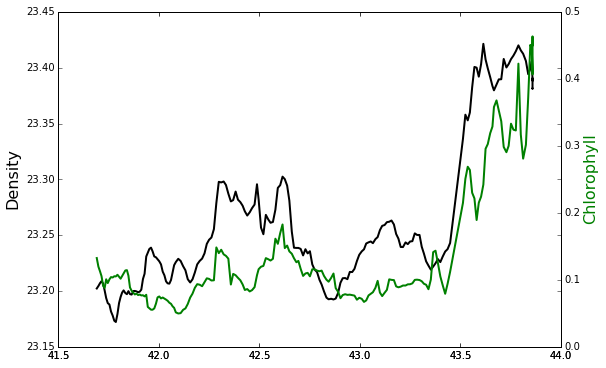

Segment 7


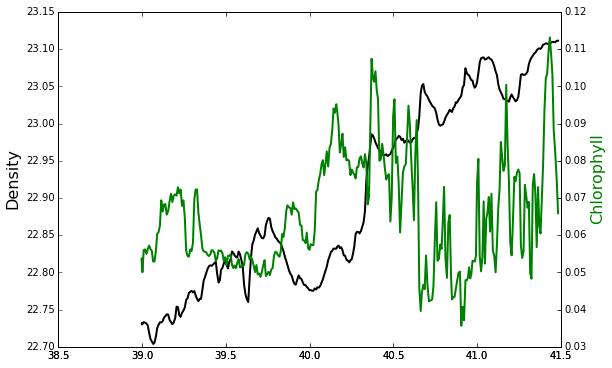

Segment 8


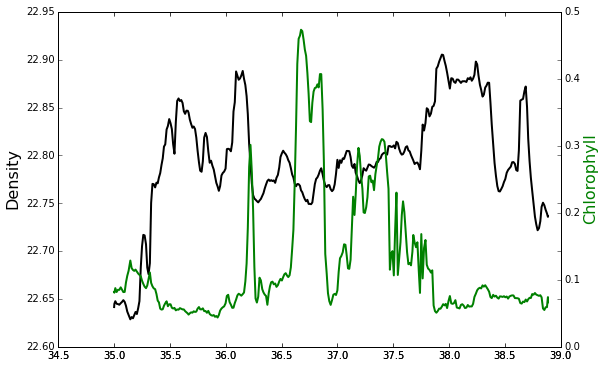

Segment 9


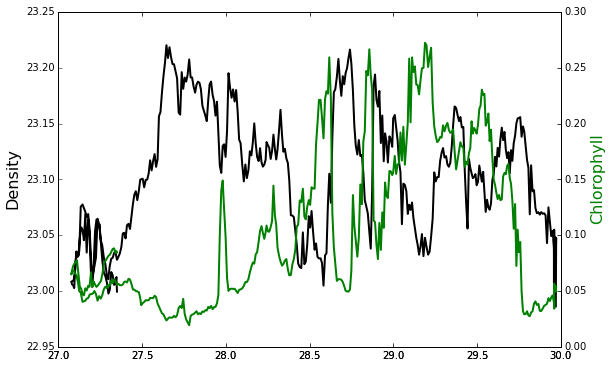

In [26]:
for i in range(1, 5):
    a = segments['start'][i]
    b = segments['end'][i]
    
    print 'Segment', i
    fig = plt.figure(i, figsize=(9, 6), dpi = 600)


    sub2 = fig.add_subplot(111)
    sub2.plot(clean['lon'][a:b],clean['density'][a:b]-1000, 'k', lw=2 )
    sub2.set_ylabel('Density', fontsize = 16)

    ax2 = fig.add_subplot(111, sharex=sub2, frameon=False)
    ax2.plot(clean['lon'][a:b],clean['chl'][a:b], 'g' , lw=2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Chlorophyll', color = 'g', fontsize = 16)
    
    plt.show()
    
for i in range(5, 10):
    a = segments['start'][i]
    b = segments['end'][i]
    print 'Segment', i
    fig = plt.figure(i, figsize=(9, 6), dpi = 600)


    sub2 = fig.add_subplot(111)
    sub2.plot(clean['lat'][a:b],clean['density'][a:b]-1000, 'k', lw=2 )
    sub2.set_ylabel('Density', fontsize = 16)

    ax2 = fig.add_subplot(111, sharex=sub2, frameon=False)
    ax2.plot(clean['lat'][a:b],clean['chl'][a:b], 'g' , lw=2)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel('Chlorophyll', color = 'g', fontsize = 16)
    
    plt.show()